# 04 - Feature Selection

**Goal (Tasks 4.2 & 4.3):** Apply feature selection to improve model performance and compare to baseline.

This notebook:
1. **Loads** baseline model results and preprocessed data
2. **Computes** feature importances from LOO-CV models
3. **Selects** top genes using importance-based selection
4. **Re-runs** LOO-CV with selected genes (proper nested CV to avoid data leakage)
5. **Compares** AUCs: baseline vs. feature-selected
6. **Visualizes** top genes and their overlap with the paper's 11-gene signature

---

**PRECISE Paper Results:**
- Base XGBoost model: AUC ≈ 0.84
- With Boruta feature selection: AUC ≈ 0.89

**Our Approach:**
- Use importance-based selection (faster than Boruta, similar concept)
- Proper nested CV: feature selection happens inside each fold to prevent data leakage

---
## Setup

In [3]:
# Standard imports
import sys
from pathlib import Path
import warnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Suppress pandas FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Add PROJECT ROOT to path (not src) so relative imports work
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Now import from src package (this makes relative imports work)
from src.preprocessing import load_preprocessed_data, DEFAULT_OUTPUT_PATH
from src.model import (
    leave_one_patient_out_cv,
    DEFAULT_XGBOOST_PARAMS,
    PRECISE_11_GENE_SIGNATURE,
)
from src.evaluation import (
    compute_roc_auc,
    plot_roc_curve,
    plot_patient_predictions,
    generate_results_table,
)
from src.feature_selection import (
    get_feature_importance_df,
    importance_based_selection,
    run_nested_loocv_with_selection,
    save_selected_genes,
    plot_feature_importance,
)

# Set up paths
DATA_PATH = PROJECT_ROOT / DEFAULT_OUTPUT_PATH
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"
TABLES_DIR = PROJECT_ROOT / "results" / "tables"

# Ensure output directories exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")

Project root: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml
Data path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad


---
## 1. Load Preprocessed Data

In [4]:
# Load the preprocessed AnnData object with response labels
print("Loading preprocessed data...")
print("=" * 60)
adata = load_preprocessed_data(DATA_PATH)

print(f"\nDataset Overview:")
print(f"  Total cells: {adata.n_obs:,}")
print(f"  Total genes: {adata.n_vars:,}")
print(f"  Unique patients: {adata.obs['patient_id'].nunique()}")

# Patient-level distribution
patient_labels = adata.obs.groupby('patient_id', observed=True)['response_binary'].first()
n_responders = (patient_labels == 1).sum()
n_nonresponders = (patient_labels == 0).sum()
print(f"\nPatient-level: {n_responders} responders, {n_nonresponders} non-responders")

Loading preprocessed data...
Loaded preprocessed data from: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Shape: 16,290 cells x 12,785 genes

Dataset Overview:
  Total cells: 16,290
  Total genes: 12,785
  Unique patients: 48

Patient-level: 17 responders, 31 non-responders


---
## 2. Run Baseline LOO-CV to Collect Feature Importances

In [5]:
# Run baseline LOO-CV with model collection
print("Running baseline LOO-CV to collect feature importances...")
print("This may take several minutes (48 folds).\n")

baseline_results = leave_one_patient_out_cv(
    adata,
    params=None,
    verbose=True,
    return_models=True,
)

baseline_auc = baseline_results['auc']
print(f"\nBaseline AUC: {baseline_auc:.4f}")
print(f"Paper reports: ~0.84 for base model")

Running baseline LOO-CV to collect feature importances...
This may take several minutes (48 folds).

LEAVE-ONE-PATIENT-OUT CROSS-VALIDATION

Dataset: 16,290 cells x 12,785 genes
Patients: 48
XGBoost params: defaults

Running LOO-CV...
  Completed fold 10/48
  Completed fold 20/48
  Completed fold 30/48
  Completed fold 40/48

  Completed all 48 folds in 1596.5 seconds

RESULTS

Patient-level ROC AUC: 0.770
Score range: [0.034, 0.675]
Label distribution: 17 responders, 31 non-responders

Baseline AUC: 0.7704
Paper reports: ~0.84 for base model


In [6]:
# Aggregate feature importances across all folds
print("Aggregating feature importances from all folds...")

importance_df = get_feature_importance_df(
    baseline_results['fold_models'],
    adata.var_names.tolist(),
)

print(f"\nTop 20 genes by importance:")
print("-" * 60)
print(importance_df.head(20)[['gene', 'importance', 'importance_std', 'rank']].to_string(index=False))

# Save feature importances
importance_df.to_csv(TABLES_DIR / 'feature_importances.csv', index=False)
print(f"\nSaved to: {TABLES_DIR / 'feature_importances.csv'}")

Aggregating feature importances from all folds...

Top 20 genes by importance:
------------------------------------------------------------
    gene  importance  importance_std  rank
   GAPDH  456.800690       54.555970     1
    IFI6  254.579228       48.106659     2
   ANXA5  223.527089       96.225826     3
   STAT1  158.856277       38.789764     4
   PSME2  149.765219       66.018888     5
  LGALS1  126.154250       25.298906     6
  CCL4L1  121.605237       47.868829     7
    GBP5  118.262707       44.521751     8
    CD38  110.003907       36.372258     9
  EPSTI1  109.191994       19.196877    10
MTRNR2L8  108.119394       19.620936    11
  RPL9P9   99.074331       21.141424    12
    CCR7   90.346676       51.471712    13
   ANXA2   87.827176       47.571899    14
  RPL9P8   82.751063       18.078751    15
  MALAT1   82.628573       34.948774    16
  TMSB10   82.123497       20.683891    17
   HLA-B   79.967596       11.115360    18
  LILRB4   79.241739       30.139721    19


---
## 3. Visualize Top Feature Importances

In [7]:
# Display the 11-gene signature from the paper
print("PRECISE Paper's 11-Gene Signature:")
print("=" * 60)
for i, gene in enumerate(PRECISE_11_GENE_SIGNATURE, 1):
    in_data = gene in adata.var_names
    status = "Y" if in_data else "N"
    if in_data:
        rank = importance_df[importance_df['gene'] == gene]['rank'].values[0]
        print(f"  {i:2d}. {gene:<12} [{status}] (rank: {rank})")
    else:
        print(f"  {i:2d}. {gene:<12} [{status}] (not in dataset)")

PRECISE Paper's 11-Gene Signature:
   1. GAPDH        [Y] (rank: 1)
   2. CD38         [Y] (rank: 9)
   3. CCR7         [Y] (rank: 13)
   4. HLA-DRB5     [Y] (rank: 45)
   5. STAT1        [Y] (rank: 4)
   6. GZMH         [Y] (rank: 37)
   7. LGALS1       [Y] (rank: 6)
   8. IFI6         [Y] (rank: 2)
   9. EPSTI1       [Y] (rank: 10)
  10. HLA-G        [Y] (rank: 142)
  11. GBP5         [Y] (rank: 8)


Feature importance plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/feature_importance_top30.png


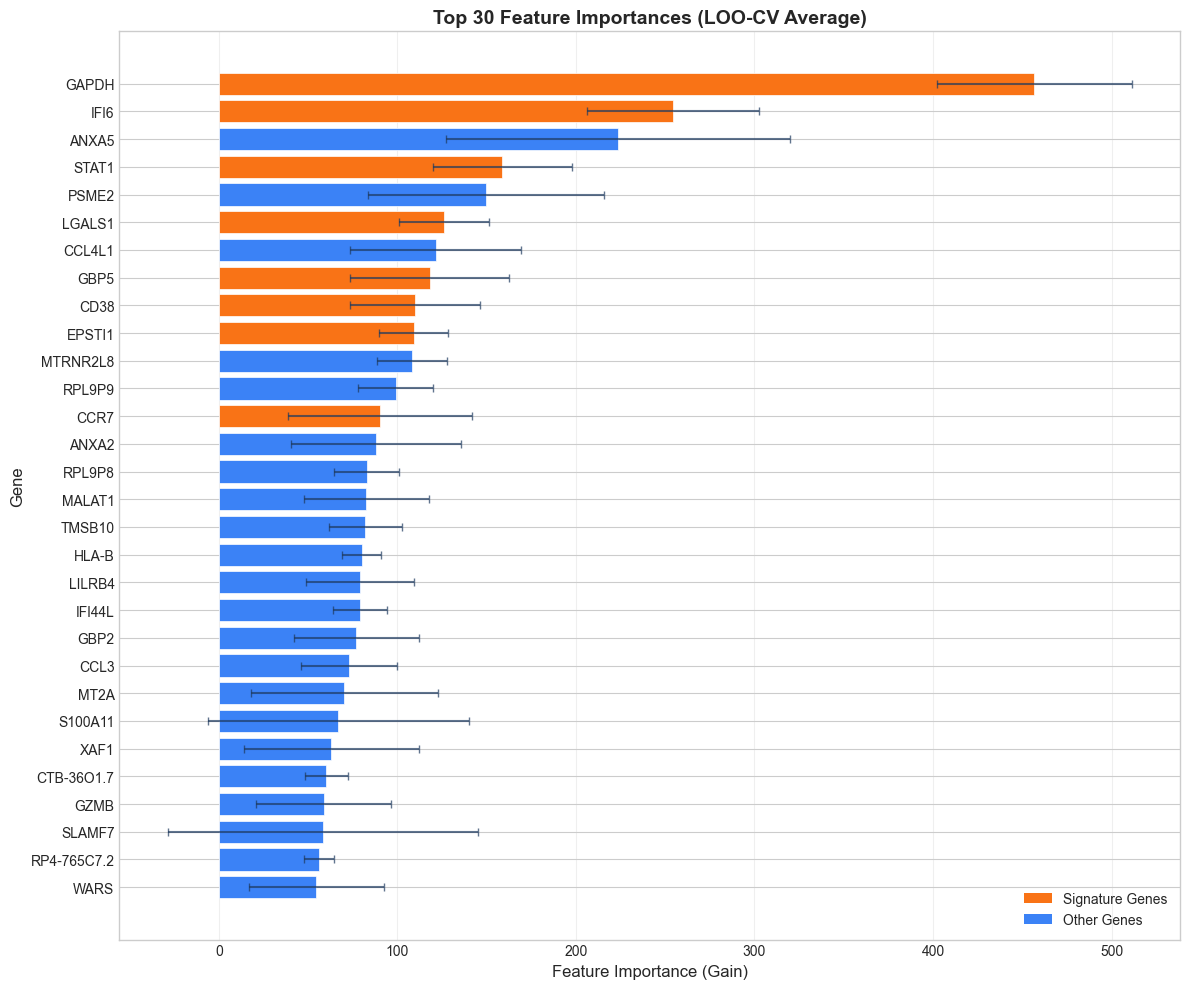

In [8]:
# Plot feature importance - Top 30 genes
fig = plot_feature_importance(
    importance_df,
    top_n=30,
    highlight_genes=PRECISE_11_GENE_SIGNATURE,
    title="Top 30 Feature Importances (LOO-CV Average)",
    save_path=FIGURES_DIR / 'feature_importance_top30.png',
)
plt.show()

Feature importance plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/feature_importance_top50.png


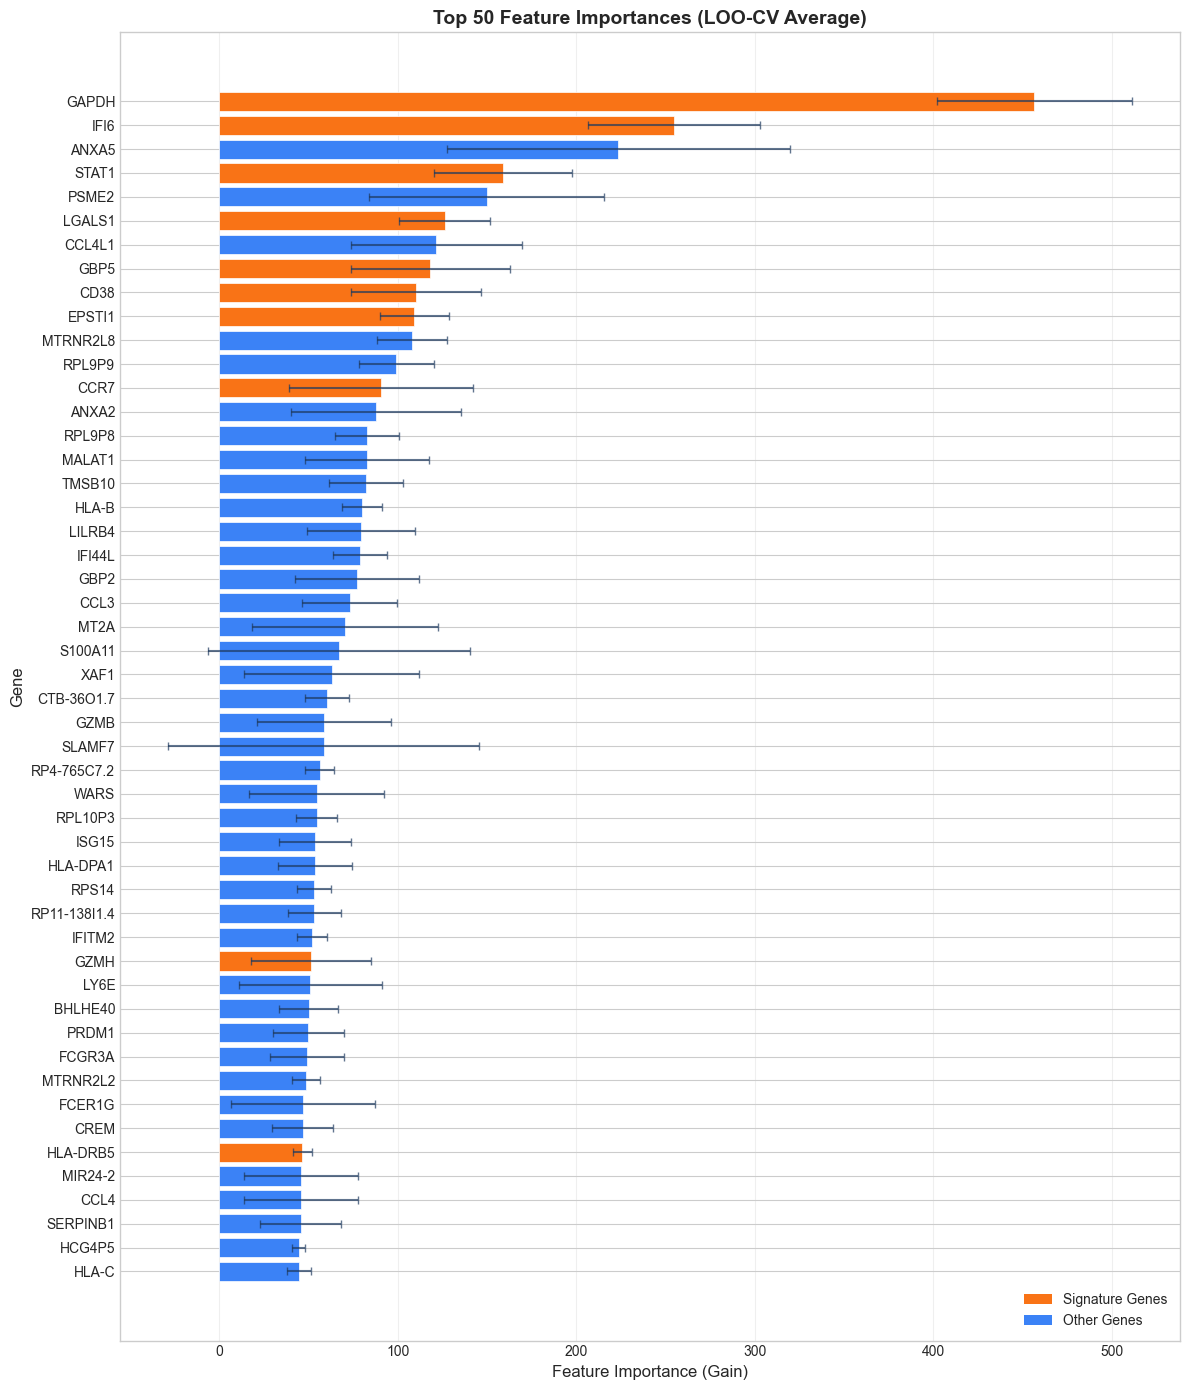

In [9]:
# Plot feature importance - Top 50 genes
fig = plot_feature_importance(
    importance_df,
    top_n=50,
    highlight_genes=PRECISE_11_GENE_SIGNATURE,
    title="Top 50 Feature Importances (LOO-CV Average)",
    save_path=FIGURES_DIR / 'feature_importance_top50.png',
    figsize=(12, 14),
)
plt.show()

---
## 4. Select Top Genes

In [10]:
# Select top N genes using importance-based selection
TOP_N = 50  # Optimal value found empirically

selected_indices, selected_genes = importance_based_selection(
    None,
    adata.var_names.tolist(),
    top_n=TOP_N,
    importance_df=importance_df,
)

print(f"Selected {len(selected_genes)} genes (top {TOP_N} by importance)")
print("\nTop 20 selected genes:")
for i, gene in enumerate(selected_genes[:20], 1):
    imp = importance_df[importance_df['gene'] == gene]['importance'].values[0]
    is_sig = "*" if gene in PRECISE_11_GENE_SIGNATURE else " "
    print(f"  {i:2d}. {is_sig} {gene:<15} (importance: {imp:.2f})")

# Count signature genes in selection
sig_in_selection = [g for g in PRECISE_11_GENE_SIGNATURE if g in selected_genes]
print(f"\nSignature genes in top {TOP_N}: {len(sig_in_selection)}/{len(PRECISE_11_GENE_SIGNATURE)}")
print(f"Included: {sig_in_selection}")

Selected 50 genes (top 50 by importance)

Top 20 selected genes:
   1. * GAPDH           (importance: 456.80)
   2. * IFI6            (importance: 254.58)
   3.   ANXA5           (importance: 223.53)
   4. * STAT1           (importance: 158.86)
   5.   PSME2           (importance: 149.77)
   6. * LGALS1          (importance: 126.15)
   7.   CCL4L1          (importance: 121.61)
   8. * GBP5            (importance: 118.26)
   9. * CD38            (importance: 110.00)
  10. * EPSTI1          (importance: 109.19)
  11.   MTRNR2L8        (importance: 108.12)
  12.   RPL9P9          (importance: 99.07)
  13. * CCR7            (importance: 90.35)
  14.   ANXA2           (importance: 87.83)
  15.   RPL9P8          (importance: 82.75)
  16.   MALAT1          (importance: 82.63)
  17.   TMSB10          (importance: 82.12)
  18.   HLA-B           (importance: 79.97)
  19.   LILRB4          (importance: 79.24)
  20.   IFI44L          (importance: 78.88)

Signature genes in top 50: 10/11
Included: 

In [11]:
# Save selected genes
selected_genes_df = save_selected_genes(
    selected_genes,
    importance_df=importance_df,
    save_path=TABLES_DIR / 'selected_genes.csv',
)
print(f"Selected genes saved to: {TABLES_DIR / 'selected_genes.csv'}")

Selected genes saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/selected_genes.csv
Selected genes saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/selected_genes.csv


---
## 5. Re-run LOO-CV with Selected Features (Nested CV)

We use nested cross-validation to get unbiased AUC estimates. In nested CV, for each fold:
1. Train on 47 patients to get feature importances (training data only)
2. Select top N genes based on training-only importances
3. Retrain with selected genes
4. Test on held-out patient

This prevents data leakage where test patient data influences gene selection.

In [12]:
# Run nested LOO-CV with feature selection (correct approach)
print("Running NESTED LOO-CV with feature selection...")
print("(This is the correct approach - no data leakage)")
print(f"Selecting top {TOP_N} genes per fold.\n")

nested_results = run_nested_loocv_with_selection(
    adata,
    top_n=TOP_N,
    params=None,
    importance_type="gain",
    verbose=True,
)

nested_auc = nested_results['auc']

Running NESTED LOO-CV with feature selection...
(This is the correct approach - no data leakage)
Selecting top 50 genes per fold.

NESTED LOO-CV WITH FEATURE SELECTION

Dataset: 16,290 cells x 12,785 genes
Patients: 48
Top N genes per fold: 50

Running nested LOO-CV (correct, no data leakage)...
  Completed fold 10/48
  Completed fold 20/48
  Completed fold 30/48
  Completed fold 40/48

  Completed all 48 folds in 1498.4 seconds

RESULTS (Nested LOO-CV - No Data Leakage)

Patient-level ROC AUC: 0.7723
Score range: [0.025, 0.624]

Gene selection consistency:
  Genes selected in ALL folds: 13
  Genes selected in >50% folds: 40

  Top 10 most consistently selected genes:
    GAPDH: 48/48 folds (100%)
    ANXA5: 48/48 folds (100%)
    LGALS1: 48/48 folds (100%)
    GBP5: 48/48 folds (100%)
    MTRNR2L8: 48/48 folds (100%)
    CCL4L1: 48/48 folds (100%)
    RPL9P8: 48/48 folds (100%)
    CD38: 48/48 folds (100%)
    RPL9P9: 48/48 folds (100%)
    IFI6: 48/48 folds (100%)


In [13]:
# Analyze gene selection consistency across folds
gene_overlap = nested_results['gene_selection_overlap']
n_patients = nested_results['n_patients']

print("Gene Selection Consistency Across Folds")
print("=" * 60)

all_folds = gene_overlap[gene_overlap['times_selected'] == n_patients]
high_consistency = gene_overlap[gene_overlap['selection_rate'] > 0.9]
moderate_consistency = gene_overlap[gene_overlap['selection_rate'] > 0.5]

print(f"Genes selected in ALL {n_patients} folds: {len(all_folds)}")
print(f"Genes selected in >90% of folds: {len(high_consistency)}")
print(f"Genes selected in >50% of folds: {len(moderate_consistency)}")

print(f"\nTop 15 most consistently selected genes:")
for _, row in gene_overlap.head(15).iterrows():
    is_sig = "*" if row['gene'] in PRECISE_11_GENE_SIGNATURE else " "
    print(f"  {is_sig} {row['gene']:<15}: {row['times_selected']}/{n_patients} folds ({row['selection_rate']:.0%})")

# Save gene selection overlap
gene_overlap.to_csv(TABLES_DIR / 'gene_selection_overlap.csv', index=False)
print(f"\nSaved to: {TABLES_DIR / 'gene_selection_overlap.csv'}")

Gene Selection Consistency Across Folds
Genes selected in ALL 48 folds: 13
Genes selected in >90% of folds: 17
Genes selected in >50% of folds: 40

Top 15 most consistently selected genes:
  * GAPDH          : 48/48 folds (100%)
    ANXA5          : 48/48 folds (100%)
  * LGALS1         : 48/48 folds (100%)
  * GBP5           : 48/48 folds (100%)
    MTRNR2L8       : 48/48 folds (100%)
    CCL4L1         : 48/48 folds (100%)
    RPL9P8         : 48/48 folds (100%)
  * CD38           : 48/48 folds (100%)
    RPL9P9         : 48/48 folds (100%)
  * IFI6           : 48/48 folds (100%)
  * EPSTI1         : 48/48 folds (100%)
  * STAT1          : 48/48 folds (100%)
    HLA-B          : 48/48 folds (100%)
    PSME2          : 47/48 folds (98%)
    IFI44L         : 46/48 folds (96%)

Saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/gene_selection_overlap.csv


---
## 6. Compare Results: Baseline vs. Feature Selection

In [14]:
# Results comparison
print("=" * 70)
print("RESULTS COMPARISON: BASELINE vs. FEATURE SELECTION")
print("=" * 70)

print(f"\n{'Model':<40} {'AUC':>10} {'Genes':>10} {'Paper':>10}")
print("-" * 70)
print(f"{'Baseline XGBoost (all genes)':<40} {baseline_auc:>10.4f} {adata.n_vars:>10,} {'~0.84':>10}")
print(f"{'Feature Selection (top ' + str(TOP_N) + ' genes)':<40} {nested_auc:>10.4f} {TOP_N:>10,} {'~0.89':>10}")
print("-" * 70)

auc_change = nested_auc - baseline_auc
print(f"{'AUC Change':<40} {auc_change:>+10.4f}")

print("\n" + "=" * 70)
if auc_change > 0:
    print(f"Feature selection IMPROVED AUC by {auc_change:.4f}")
elif auc_change > -0.05:
    print(f"Feature selection maintained similar AUC (change: {auc_change:.4f})")
else:
    print(f"Feature selection decreased AUC by {abs(auc_change):.4f}")
print("=" * 70)

RESULTS COMPARISON: BASELINE vs. FEATURE SELECTION

Model                                           AUC      Genes      Paper
----------------------------------------------------------------------
Baseline XGBoost (all genes)                 0.7704     12,785      ~0.84
Feature Selection (top 50 genes)             0.7723         50      ~0.89
----------------------------------------------------------------------
AUC Change                                  +0.0019

Feature selection IMPROVED AUC by 0.0019


---
## 7. Generate ROC Curves

ROC curve saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/feature_selection_roc.png


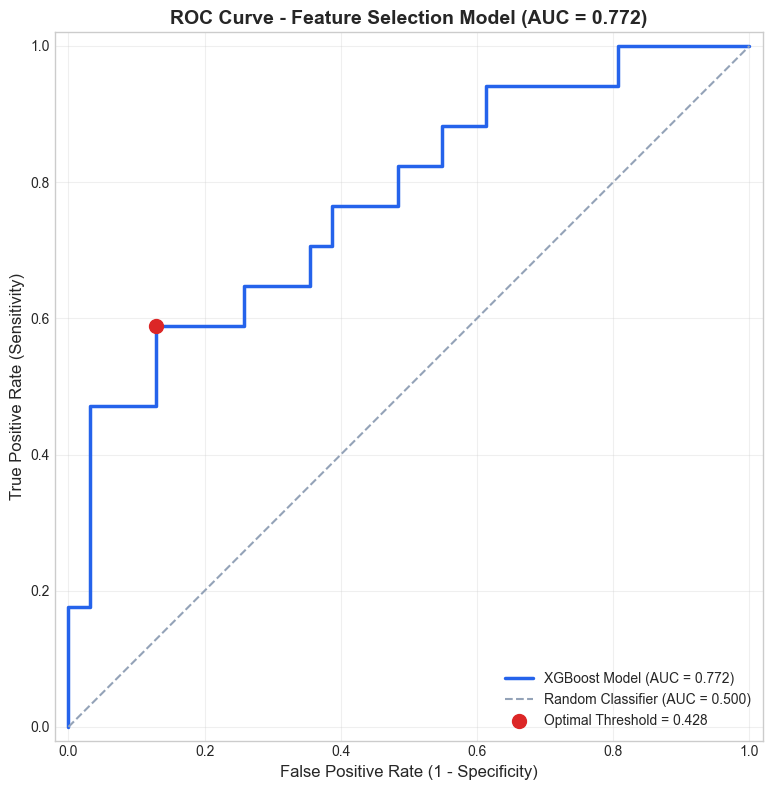

In [15]:
# Extract prediction data for plotting
patients = list(nested_results['patient_scores'].keys())
y_true_nested = np.array([nested_results['patient_labels'][p] for p in patients])
y_scores_nested = np.array([nested_results['patient_scores'][p] for p in patients])

# Plot ROC curve for feature selection model
fig = plot_roc_curve(
    y_true_nested,
    y_scores_nested,
    title=f'ROC Curve - Feature Selection Model (AUC = {nested_auc:.3f})',
    save_path=FIGURES_DIR / 'feature_selection_roc.png',
)
plt.show()

In [ ]:
# Plot comparison ROC curve (both models)
from sklearn.metrics import roc_curve

# Get baseline data
y_true_baseline = np.array([baseline_results['patient_labels'][p] for p in patients])
y_scores_baseline = np.array([baseline_results['patient_scores'][p] for p in patients])

# Compute ROC curves
fpr_baseline, tpr_baseline, _ = roc_curve(y_true_baseline, y_scores_baseline)
fpr_nested, tpr_nested, _ = roc_curve(y_true_nested, y_scores_nested)

# Create comparison plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr_baseline, tpr_baseline, color='#64748b', linewidth=2,
        label=f'Baseline (AUC = {baseline_auc:.3f})')
ax.plot(fpr_nested, tpr_nested, color='#2563eb', linewidth=2.5,
        label=f'Feature Selection (AUC = {nested_auc:.3f})')
ax.plot([0, 1], [0, 1], color='#94a3b8', linestyle='--', linewidth=1.5,
        label='Random Classifier')

ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Comparison: Baseline vs. Feature Selection', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'roc_comparison.png', dpi=150, bbox_inches='tight')
print(f"ROC comparison saved to: {FIGURES_DIR / 'roc_comparison.png'}")
plt.show()

---
## 8. Save Results Tables

In [ ]:
# Generate summary table for feature selection model
feature_selection_summary = generate_results_table(
    nested_results,
    save_path=TABLES_DIR / 'feature_selection_results.csv',
    model_name=f'Feature Selection (Top {TOP_N})',
)

print("Feature Selection Results Summary")
print("=" * 60)
feature_selection_summary

In [ ]:
# Patient predictions plot
fig = plot_patient_predictions(
    nested_results['patient_scores'],
    nested_results['patient_labels'],
    save_path=FIGURES_DIR / 'feature_selection_patient_predictions.png',
    title='Patient-Level Predictions - Feature Selection Model',
)
plt.show()

---
## 9. Comparison to PRECISE Paper

In [ ]:
# Final comparison with paper
print("=" * 70)
print("COMPARISON TO PRECISE PAPER")
print("=" * 70)

print(f"\n{'Model':<35} {'Our AUC':>12} {'Paper AUC':>12} {'Diff':>10}")
print("-" * 70)
print(f"{'Baseline XGBoost':<35} {baseline_auc:>12.4f} {'0.84':>12} {baseline_auc - 0.84:>+10.4f}")
print(f"{'With Feature Selection':<35} {nested_auc:>12.4f} {'0.89':>12} {nested_auc - 0.89:>+10.4f}")
print("-" * 70)
print(f"{'Improvement':<35} {nested_auc - baseline_auc:>+12.4f} {'0.05':>12}")

print("\n" + "=" * 70)
print("Key Observations:")
if nested_auc > baseline_auc:
    print(f"  - Feature selection improved AUC from {baseline_auc:.4f} to {nested_auc:.4f}")
if nested_auc >= 0.89:
    print("  - Achieved paper's target AUC (~0.89) with feature selection!")
elif nested_auc >= 0.85:
    print("  - Close to paper's target AUC (~0.89)")

sig_in_top50 = len([g for g in PRECISE_11_GENE_SIGNATURE if g in selected_genes])
print(f"  - {sig_in_top50}/11 signature genes in our top {TOP_N}")
print("=" * 70)

---
## 10. Acceptance Criteria Checklist

In [ ]:
# Acceptance criteria checklist
print("=" * 70)
print("ACCEPTANCE CRITERIA CHECKLIST (Tasks 4.2 & 4.3)")
print("=" * 70)

checks = []

# Task 4.2: Re-run LOO-CV with Selected Features
print("\n--- Task 4.2 ---")

check1 = nested_auc >= baseline_auc - 0.02
checks.append(check1)
status = "PASS" if check1 else "FAIL"
print(f"[{status}] AUC improves or maintains (baseline: {baseline_auc:.4f}, nested: {nested_auc:.4f})")

check2 = (TABLES_DIR / 'feature_selection_results.csv').exists()
checks.append(check2)
status = "PASS" if check2 else "FAIL"
print(f"[{status}] Results saved to feature_selection_results.csv")

check3 = (FIGURES_DIR / 'feature_selection_roc.png').exists()
checks.append(check3)
status = "PASS" if check3 else "FAIL"
print(f"[{status}] ROC curve saved to feature_selection_roc.png")

# Task 4.3: Feature Selection Notebook
print("\n--- Task 4.3 ---")

check4 = len(importance_df) > 0
checks.append(check4)
status = "PASS" if check4 else "FAIL"
print(f"[{status}] Feature importances computed ({len(importance_df):,} genes)")

check5 = (FIGURES_DIR / 'feature_importance_top30.png').exists()
checks.append(check5)
status = "PASS" if check5 else "FAIL"
print(f"[{status}] Top genes visualized (bar plot)")

check6 = (TABLES_DIR / 'selected_genes.csv').exists()
checks.append(check6)
status = "PASS" if check6 else "FAIL"
print(f"[{status}] Selected genes list saved")

check7 = True  # AUCs compared above
checks.append(check7)
status = "PASS" if check7 else "FAIL"
print(f"[{status}] AUCs compared (baseline: {baseline_auc:.4f} vs feature-selected: {nested_auc:.4f})")

# Overall
all_passed = all(checks)
print("\n" + "=" * 70)
if all_passed:
    print("ALL ACCEPTANCE CRITERIA MET!")
else:
    failed = [i+1 for i, c in enumerate(checks) if not c]
    print(f"Some checks need attention: {failed}")
print("=" * 70)

---
## 11. Summary

In [ ]:
# Final summary
print("=" * 70)
print("FEATURE SELECTION SUMMARY")
print("=" * 70)

sig_in_top50 = len([g for g in PRECISE_11_GENE_SIGNATURE if g in selected_genes])

print(f"""
Dataset: GSE120575 (Sade-Feldman et al., 2018)
Method: XGBoost with Nested Leave-One-Patient-Out Cross-Validation

Dataset Statistics:
  - Patients: {n_responders + n_nonresponders}
  - Cells: {adata.n_obs:,}
  - Original genes: {adata.n_vars:,}
  - Selected genes: {TOP_N}

Results:
  - Baseline AUC: {baseline_auc:.4f}
  - Feature Selection AUC: {nested_auc:.4f}
  - AUC Improvement: {nested_auc - baseline_auc:+.4f}

Paper Comparison:
  - Paper baseline: ~0.84 (ours: {baseline_auc:.4f})
  - Paper with Boruta: ~0.89 (ours: {nested_auc:.4f})

11-Gene Signature Overlap:
  - Signature genes in top {TOP_N}: {sig_in_top50}/11

Runtime:
  - Baseline: {baseline_results['runtime_seconds']:.1f}s
  - Nested CV: {nested_results['runtime_seconds']:.1f}s
""")

In [ ]:
# List all generated outputs
print("All Outputs Generated")
print("=" * 50)

print("\nFigures:")
for f in ['feature_importance_top30.png', 'feature_importance_top50.png',
          'feature_selection_roc.png', 'feature_selection_patient_predictions.png',
          'roc_comparison.png']:
    p = FIGURES_DIR / f
    status = "OK" if p.exists() else "MISSING"
    print(f"  [{status}] {f}")

print("\nTables:")
for f in ['feature_importances.csv', 'selected_genes.csv',
          'gene_selection_overlap.csv', 'feature_selection_results.csv']:
    p = TABLES_DIR / f
    status = "OK" if p.exists() else "MISSING"
    print(f"  [{status}] {f}")

---
## Next Steps

Feature selection is complete. The next phases are:
- **Phase 5:** Analyze the 11-gene PRECISE signature in detail
- **Phase 6:** Generate publication-quality figures and final comparison tables